In [16]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Configurations

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
noise_dim = 64

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

num_epochs = 20

# Load MNIST Dataset

In [18]:
from torchvision import datasets, transforms as T

In [19]:
train_augs = T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor()
])

In [20]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11575238.81it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 347596.65it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3214019.31it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2754160.59it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



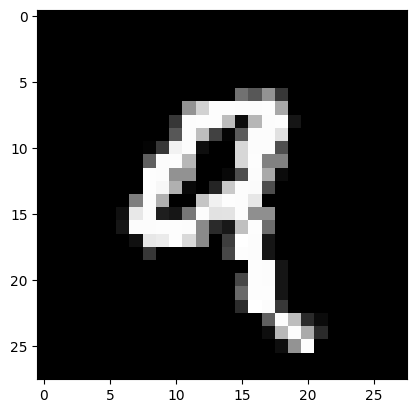

In [21]:
image, label = trainset[4]
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [22]:
print("total images present in trainset are: ", len(trainset))
print(f"shape: {image.shape}")

total images present in trainset are:  60000
shape: torch.Size([1, 28, 28])


# Load Dataset Into Batches

In [23]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [24]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [25]:
print(f"Total no. of batces in trainloader: {len(trainloader)}")

Total no. of batces in trainloader: 469


In [26]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [27]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

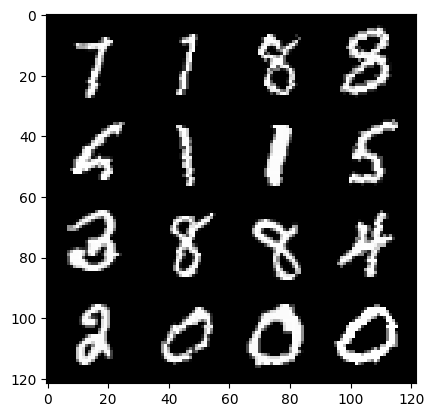

In [28]:
show_tensor_images(images)

# Create Discriminator Network

In [29]:
#In case if torch summary is not installed

!pip install torchsummary

In [30]:
from torch import nn
from torchsummary import summary

In [32]:
def get_disc_block(in_channels, out_channels, kernel_size, stride, reluNegSlope=0.2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(reluNegSlope))

In [33]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc_block1 = get_disc_block(1, 16, (3,3),2)
    self.disc_block2 = get_disc_block(16, 32, (5,5), 2)
    self.disc_block3 = get_disc_block(32, 64, (5,5), 2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 1)

  def forward(self, images):
    x1 = self.disc_block1(images)
    x2 = self.disc_block2(x1)
    x3 = self.disc_block3(x2)
    flatten = self.flatten(x3)
    out = self.linear(flatten)
    return out  # Logits, raw output without sigmoid

In [34]:
D = Discriminator()
D = D.to(device)
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [39]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh())
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

In [40]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim # 64
    self.gen_block1 = get_gen_block(noise_dim, 64 * 4, (3,3), 2)
    self.gen_block2 = get_gen_block(64 * 4, 64 * 2, (4,4), 1)
    self.gen_block3 = get_gen_block(64 * 2, 64 * 1, (3,3), 2)
    self.gen_block4 = get_gen_block(64 * 1, 1, (4,4), 2, final_block=True)

  def forward(self, random_noise_vector):
    x = random_noise_vector.view(-1, self.noise_dim, 1, 1)
    x1 = self.gen_block1(x)
    x2 = self.gen_block2(x1)
    x3 = self.gen_block3(x2)
    out = self.gen_block4(x3)
    return out

In [41]:
G = Generator(noise_dim)
G = G.to(device)
summary(G, (noise_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [42]:
# Replace Random initialized weights to Normal weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [43]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [44]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [45]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 , D_loss : 0.6843242312291029 , G_loss : 0.6907149202533877


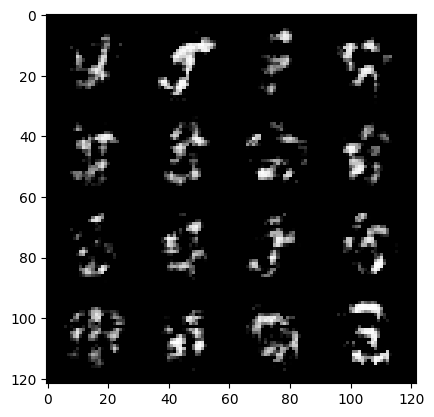

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 , D_loss : 0.6773054623908834 , G_loss : 0.7131426124684592


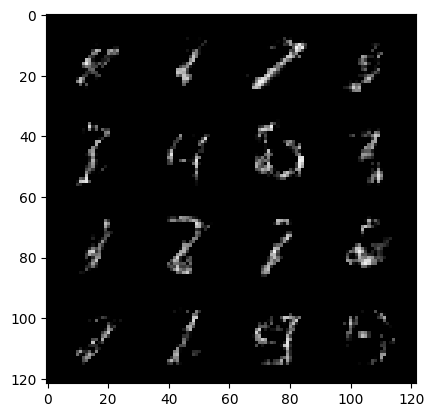

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 , D_loss : 0.6222264651042312 , G_loss : 0.7733902351688474


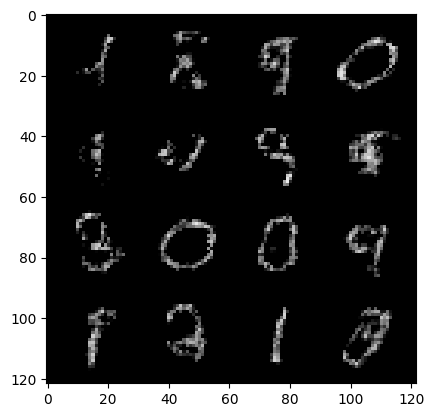

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 , D_loss : 0.5617256694511056 , G_loss : 0.8581391693686625


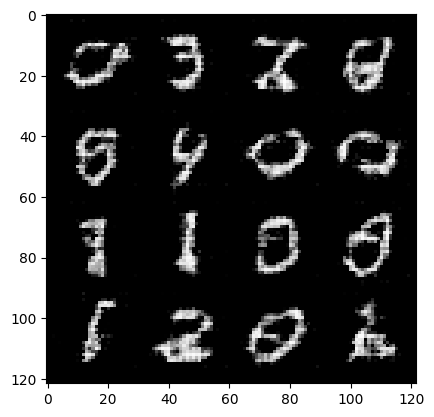

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 , D_loss : 0.5426844209750324 , G_loss : 0.9063796042633463


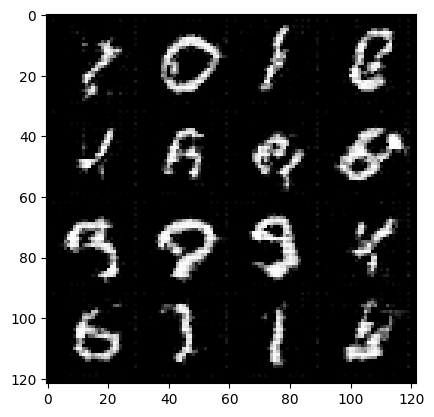

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 , D_loss : 0.5468843923702932 , G_loss : 0.9242959528335376


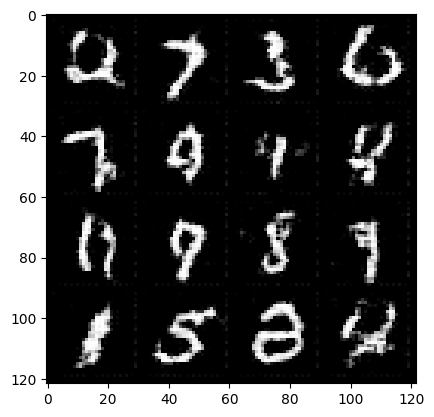

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 , D_loss : 0.5614436329809079 , G_loss : 0.9249398630819341


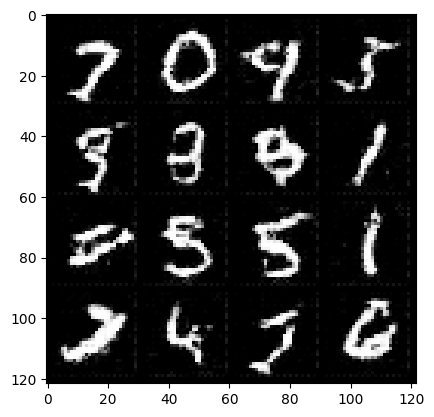

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 , D_loss : 0.5789996532997342 , G_loss : 0.9050873811565229


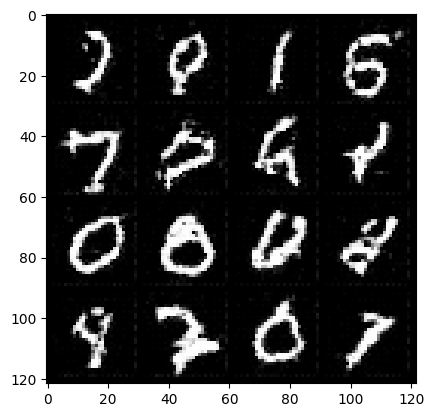

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 , D_loss : 0.5951424347820566 , G_loss : 0.8885205393152704


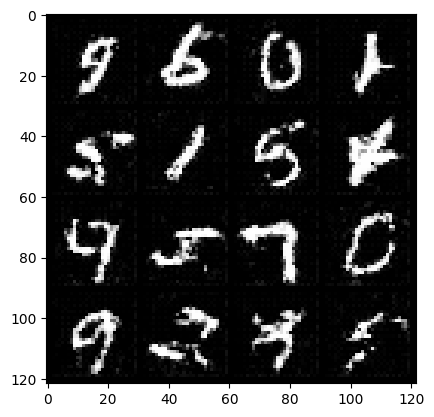

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 , D_loss : 0.6080174194470144 , G_loss : 0.8739849970793165


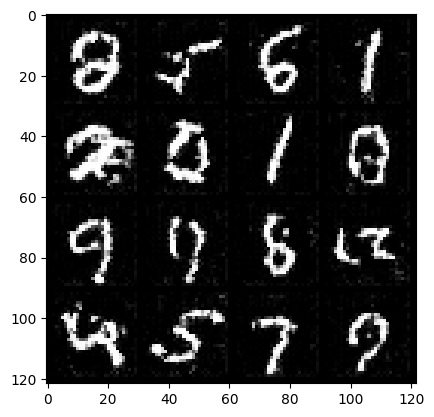

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 , D_loss : 0.6193218667115739 , G_loss : 0.8576925455380097


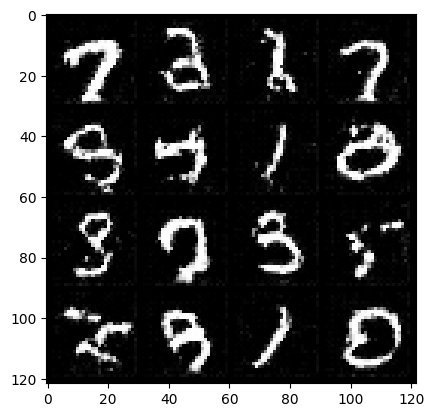

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 , D_loss : 0.628098843956807 , G_loss : 0.843200608611361


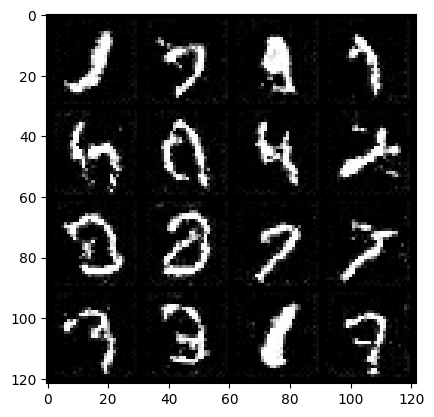

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 , D_loss : 0.6327258966116509 , G_loss : 0.8360445888311878


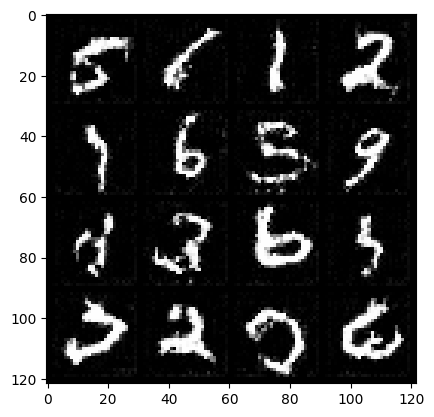

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 , D_loss : 0.6356068977923282 , G_loss : 0.8274735353394612


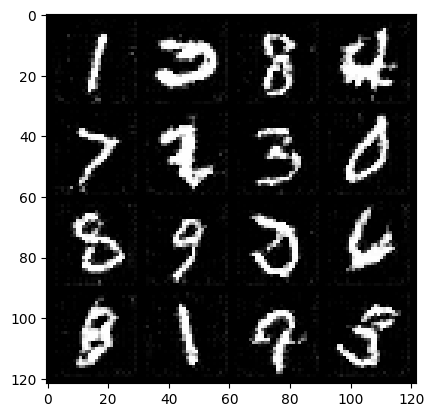

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 , D_loss : 0.6383000331392674 , G_loss : 0.8255453222850239


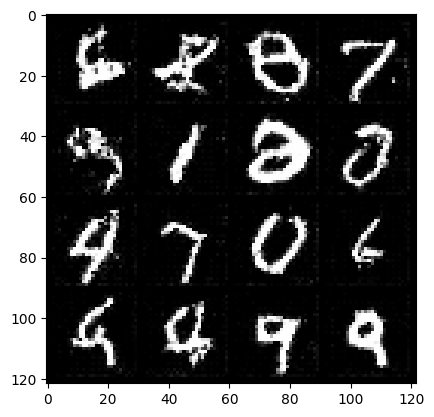

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 , D_loss : 0.6381257217067645 , G_loss : 0.824610104311758


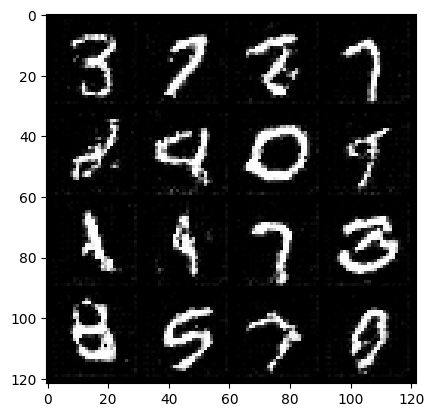

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 , D_loss : 0.6379322426151365 , G_loss : 0.8252709307141904


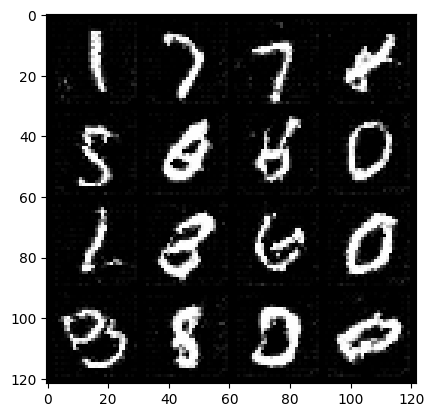

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 , D_loss : 0.639297669630315 , G_loss : 0.826251439829625


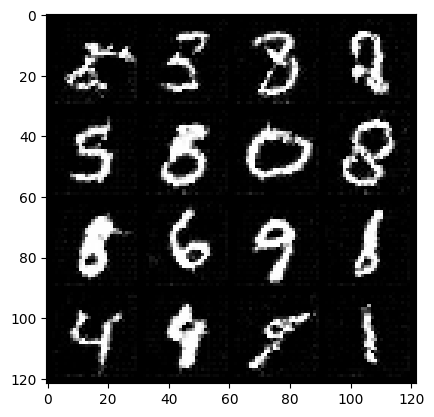

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 , D_loss : 0.639663899758223 , G_loss : 0.8237060185180289


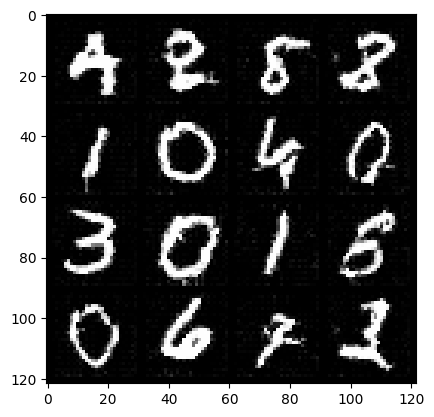

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 , D_loss : 0.638478804117581 , G_loss : 0.8255617455887133


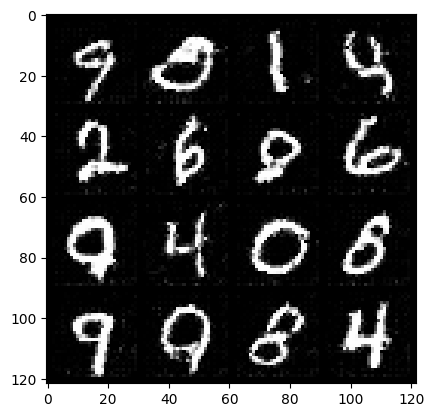

In [46]:
num_batchs = len(trainloader)
for epoch in range(num_epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)
    D_opt.zero_grad()  # dont want to accumulate grads

    # D prediction for fake
    fake_img = G(noise)
    D_pred = D(fake_img) # D prediction for fake
    D_fake_loss = fake_loss(D_pred)
    # D prediction for real
    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)
    # update weights
    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad() # dont want to accumulate grads
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_img = G(noise)
    D_pred = D(fake_img) # D prediction for fake
    G_loss = real_loss(D_pred) # G desires that D predicts all as real
    total_g_loss += G_loss.item()
    # update weights
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/num_batchs
  avg_g_loss = total_g_loss/num_batchs
  print(f"Epoch : {epoch+1} , D_loss : {avg_d_loss} , G_loss : {avg_g_loss}")
  show_tensor_images(fake_img)

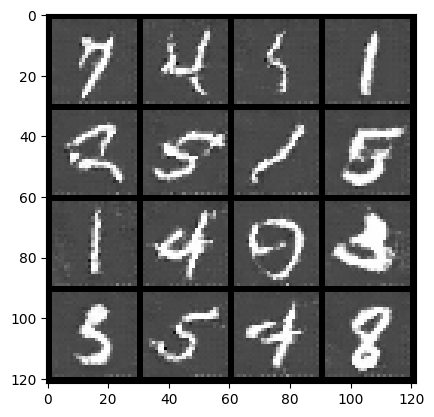

In [47]:
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)